In [ ]:
!nvidia-smi

## 1) Installing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 2) Loading dataset (from HF)


In [2]:
# enter your personal read token

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/total_non_code_mixed", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--total_non_code_mixed-2b4c0dddeda185af
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--total_non_code_mixed-2b4c0dddeda185af/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 7413
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 927
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 927
    })
})


In [5]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 7413
})

## 3) Converting to dataframe

In [6]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,If Mr MODI is so keen on eradicating corruptio...,1
1,"Greatest melancholy is what, More than half of...",1
2,Movie is on anger management..,0
3,dont agree with you on all the points but yes ...,0
4,I wrote in The Hindu on how to fight against a...,1


In [7]:
test_df = aggression_dataset['test'][:]

In [8]:
train_df['Label'].value_counts()

0    3006
1    2598
2    1809
Name: Label, dtype: int64

In [9]:
# 7413
# NAG-CAG-OAG (0-1-2) = 0.41-0.35-0.24

Seeing Distribution

In [10]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


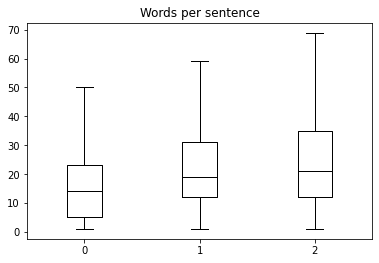

In [11]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [12]:
from transformers import AutoTokenizer

In [13]:
model_ckpt = 'l3cube-pune/hing-mbert'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
tokenizer.vocab_size

119547

In [15]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [16]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [17]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [18]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [20]:
import torch

In [21]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [22]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [24]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diptesh. Use `wandb login --relogin` to force relogin


True

In [25]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [26]:
from transformers import Trainer, TrainingArguments

In [27]:
# Defining hyperparameters
eval_batch_size = 8
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-non-code-mixed-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=4.932923543227153e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=8,
                                  weight_decay=0.17649239825343255,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.1,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="hing-mbert-non-code-mixed-DS",
                                  push_to_hub=True)

In [28]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [29]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.35, 0.44]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [30]:
from transformers import EarlyStoppingCallback

In [31]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [32]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/l3cube-pune/hing-mbert/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/99deaf3e53bff9f1eee4e865526f0dfd559fb3c6a90b66e25dcd84a2b1f0120c.380aaffc7dd55e68a2ae770db8777374a141fe08aa4caf295f7f10b0746056e3
Model config BertConfig {
  "_name_or_path": "l3cube-pune/hing-mbert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_f

  0%|          | 0/3708 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
trainer.push_to_hub()

## 8) Predictions and Results

In [ ]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

In [ ]:
preds_output_test.metrics

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

In [ ]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 